In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
alsfrs_orig_raw = pd.read_csv('ALSFRS_original.csv')
fvc_raw = pd.read_csv('fvc.csv')

In [3]:
alsfrs_orig = alsfrs_orig_raw.sort_values(by=['SubjectID','feature_delta'], axis=0).reset_index().drop(columns='index')
fvc = fvc_raw.sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')

### Creating Optimal gastrostomy Target object

 ### 01. Subtracting [FVC < 50]

In [4]:
fvc_a = fvc.groupby('SubjectID').agg(['first', 'last'])
fvc_a = fvc_a.reset_index()
fvc_a

SubjectID fvc_percent      feature_delta     
                     first last         first last
0           89          75   75             0    0
1          329          98   93             0  274
2          406          83   83             0    0
3          411          79   79             0    0
4          533          77   70             0   12
...        ...         ...  ...           ...  ...
7307    999482          79   33             0  434
7308    999823         103   94             0  184
7309    999863          40   36             0  177
7310    999880          53   49             0  266
7311    999990          83   74             0  126

[7312 rows x 5 columns]

In [5]:
# Remove rows with 'last feature_delta == first feature_delta'
fvc_a = fvc_a[fvc_a[('feature_delta', 'last')]!= fvc_a[('feature_delta', 'first')]]
fvc_a


SubjectID fvc_percent      feature_delta     
                     first last         first last
1          329          98   93             0  274
4          533          77   70             0   12
6          649          97   33             0  557
7          708          53   33             0  231
8          902          90   87             0  154
...        ...         ...  ...           ...  ...
7307    999482          79   33             0  434
7308    999823         103   94             0  184
7309    999863          40   36             0  177
7310    999880          53   49             0  266
7311    999990          83   74             0  126

[6073 rows x 5 columns]

In [6]:
# Select rows with 'first fvc_percent < 50'
fvc_a = fvc_a[fvc_a[('fvc_percent', 'first')]<50]
fvc_a = fvc_a.reset_index().drop(columns='index')
fvc_a

C:\Users\hyji1\anaconda3\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


SubjectID fvc_percent      feature_delta     
                    first last         first last
0        5291          20    6             0   47
1        6673          21    0             1   73
2       12890          30   12             0  273
3       13147          26   13             0   97
4       16459          28   13             0  130
..        ...         ...  ...           ...  ...
231    981656          15   42             0  180
232    983115          46   60             0  388
233    988844          40   25             0   85
234    991654          36   14             0  182
235    999863          40   36             0  177

[236 rows x 5 columns]

In [7]:
fvc_extent_to_remove = list(fvc_a['SubjectID'])

### 2. Subtracting [first ALSFRS-Q3 < 1]

In [8]:
len(alsfrs_orig['SubjectID'].unique())

6510

In [9]:
alsfrs_Sw = alsfrs_orig[['SubjectID', 'feature_delta', 'Q3_Swallowing']].reindex(columns=['SubjectID', 'Q3_Swallowing', 'feature_delta'])
alsfrs_Sw_a = alsfrs_Sw.groupby('SubjectID').agg(['first'])
alsfrs_Sw_b = alsfrs_Sw_a[alsfrs_Sw_a[('Q3_Swallowing','first')]>1].reset_index()
alsfrs_Sw_b

,SubjectID,Q3_Swallowing,feature_delta
,,first,first
0,329,4.0,0
1,348,4.0,0
2,533,2.0,0
3,649,2.0,0
4,708,3.0,0
...,...,...,...
6405,999166,4.0,18
6406,999482,4.0,0
6407,999823,3.0,9


In [10]:
alsfrs_filtered_extent = list(alsfrs_Sw_b['SubjectID'])

### 3. Calculating "time to [ALSFRS-Q3 <= 1]"

In [11]:
# Subtract [FVC < 50] & [first ALSFRS-Bulbar <=1.0]
alsfrs_Sw.query("SubjectID == {0}".format(alsfrs_filtered_extent), inplace=True)
alsfrs_Sw = alsfrs_Sw[~alsfrs_Sw['SubjectID'].isin(fvc_extent_to_remove)]

In [12]:
# Find the first time of [ALSFRS-Bulbar <=1.0]
Optimal_event = alsfrs_Sw[alsfrs_Sw['Q3_Swallowing']<=1].groupby('SubjectID').agg(['first']).reset_index()
Optimal_event

,SubjectID,Q3_Swallowing,feature_delta
,,first,first
0,533,1.0,287
1,649,1.0,425
2,1234,1.0,245
3,1736,1.0,244
4,3551,1.0,501
...,...,...,...
1155,995893,1.0,149
1156,996401,1.0,420
1157,996711,0.0,379


In [13]:
# Coding [ALSFRS-Q3<=1] event as '1'
Optimal_event_1 = Optimal_event.iloc[:, [0,-1]]
Optimal_event_1.columns = ['SubjectID', 'time_opt']

Optimal_event_1_sublist = list(Optimal_event['SubjectID'])

Optimal_event_1['status_opt'] = 1
print("There are",len(Optimal_event_1['SubjectID'].unique()), "subjects whose status_opt = 1")

There are 1160 subjects whose status_opt = 1


In [14]:
# Otherwise '0'
Optimal_event_0 = alsfrs_Sw[~alsfrs_Sw['SubjectID'].isin(Optimal_event_1_sublist)]
Optimal_event_0 = Optimal_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=('Q3_Swallowing', 'last'))
Optimal_event_0.columns = ['SubjectID', 'time_opt']
Optimal_event_0['status_opt'] = 0
print("There are",len(Optimal_event_0['SubjectID'].unique()), "subjects whose status_opt = 0")

There are 5086 subjects whose status_opt = 0


In [15]:
alsfrs_Sw_coded = pd.concat([Optimal_event_1, Optimal_event_0]).sort_values(by='SubjectID', axis=0)
alsfrs_Sw_coded = alsfrs_Sw_coded.reset_index()
alsfrs_Sw_coded.drop(columns='index', inplace=True)

In [16]:
Optimal_Gas = alsfrs_Sw_coded.copy()
sub_list = list(Optimal_Gas['SubjectID'])

In [17]:
X_imputed = pd.read_csv('imputed features_final.csv')
sub_list_0 = list(X_imputed['SubjectID'])

In [18]:
Optimal_Gas = Optimal_Gas[Optimal_Gas['time_opt']!=0]
Optimal_Gas.query("SubjectID == {0}".format(sub_list_0), inplace=True)
Optimal_Gas = Optimal_Gas[Optimal_Gas['time_opt']>92]
Optimal_Gas

,SubjectID,time_opt,status_opt
0,329,274,0
1,348,401,0
2,533,287,1
4,708,231,0
5,902,154,0
...,...,...,...
6234,998519,280,0
6241,999166,390,0
6243,999823,184,0
6244,999880,266,0


In [19]:
Optimal_Gas.to_csv('Optimal target.csv')

### Creating Real gastrostomy Target object

In [49]:
alsfrs_orig = pd.read_csv('ALSFRS_original.csv') 

In [50]:
gastro = alsfrs_orig[['SubjectID', 'Q5b_Cutting_with_Gastrostomy', 'feature_delta']].sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')
gastro

,SubjectID,Q5b_Cutting_with_Gastrostomy,feature_delta
0,329,NaN,0
1,329,NaN,8
2,329,NaN,16
3,329,NaN,42
4,329,NaN,72
...,...,...,...
59255,999990,NaN,12
59256,999990,NaN,40
59257,999990,NaN,68
59258,999990,NaN,97


In [51]:
def checking_censored(x):
  
  if x.isnull().sum() == 0:
    return "Left censored"
  elif x.notnull().sum() == 0:
    return "Right censored"
  else:
    return "Normal"

aggs_by_col = {'Q5b_Cutting_with_Gastrostomy': [checking_censored], 'feature_delta': ['last']}
gastro_a = gastro.groupby('SubjectID', as_index=False).agg(aggs_by_col)
gastro_a

,SubjectID,Q5b_Cutting_with_Gastrostomy,feature_delta
,,checking_censored,last
0,329,Right censored,274
1,348,Right censored,401
2,533,Normal,378
3,586,Right censored,3
4,649,Normal,557
...,...,...,...
6505,999166,Right censored,390
6506,999482,Right censored,434
6507,999823,Left censored,184


In [52]:
#Subtract Left censored data

gastro_a.columns = ['SubjectID', 'checking_censored', 'last_feature_delta']
gastro_a = gastro_a[gastro_a['checking_censored'] != 'Left censored']
full_extent = list(gastro_a['SubjectID'])
Right_censored_extent = list(gastro_a[gastro_a['checking_censored'] == 'Right censored']['SubjectID'])
Normal_extent = list(gastro_a[gastro_a['checking_censored'] == 'Normal']['SubjectID'])

print("Total number is " + str(len(full_extent)))
print("There are " + str(len(Right_censored_extent)) + " right censored data")
print("There are " + str(len(Normal_extent)) + " normal data")


Total number is 5797
There are 4609 right censored data
There are 1188 normal data


In [53]:
# Create gastro_event_0

gastro_event_0 = gastro_a[gastro_a['checking_censored'] == 'Right censored']
gastro_event_0 = gastro_event_0.replace({'checking_censored':{'Right censored': 0}})
gastro_event_0.columns = ['SubjectID', 'status', 'time']
gastro_event_0

,SubjectID,status,time
0,329,0,274
1,348,0,401
3,586,0,3
5,708,0,231
11,2416,0,2
...,...,...,...
6504,998908,0,560
6505,999166,0,390
6506,999482,0,434
6508,999880,0,266


In [54]:
gastro_b = gastro.copy()
gastro_b.query("SubjectID == {0}".format(Normal_extent), inplace=True)
gastro_b = gastro_b.dropna(axis=0)
gastro_event_1 = pd.DataFrame(gastro_b.groupby('SubjectID')['feature_delta'].agg('first')).reset_index()
gastro_event_1.columns = ['SubjectID', 'time']
gastro_event_1['status'] = 1
gastro_event_1

,SubjectID,time,status
0,533,287,1
1,649,487,1
2,1064,0,1
3,1234,245,1
4,1736,0,1
...,...,...,...
1183,995893,175,1
1184,996401,420,1
1185,996711,379,1
1186,998047,551,1


In [55]:
gastro_event_1 = gastro_event_1[gastro_event_1['time'] != 0]
gastro_event_1

,SubjectID,time,status
0,533,287,1
1,649,487,1
3,1234,245,1
5,3551,501,1
6,4803,98,1
...,...,...,...
1183,995893,175,1
1184,996401,420,1
1185,996711,379,1
1186,998047,551,1


In [56]:
gastro_fin = pd.concat([gastro_event_1, gastro_event_0]).sort_values(by='SubjectID', axis=0)
gastro_fin = gastro_fin.reset_index().drop(columns = 'index')

In [57]:
gastro_fin.columns = ['SubjectID', 'time_real', 'status_real']
gastro_fin = gastro_fin[gastro_fin['time_real']>92]
gastro_fin

,SubjectID,time_real,status_real
0,329,274,0
1,348,401,0
2,533,287,1
4,649,487,1
5,708,231,0
...,...,...,...
5574,998908,560,0
5575,999166,390,0
5576,999482,434,0
5577,999880,266,0


### Censored vs Occured 비율 확인

In [59]:
event_distribution = pd.DataFrame(Optimal_Gas[['status_opt']].value_counts()).reset_index()
event_distribution.columns = ['status_o', 'count']
event_distribution['status_o'] = event_distribution['status_o'].astype('bool')
event_distribution = event_distribution.replace({'status_o': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)

survival = pd.read_csv('_0415_features_without_nans_survival.csv')
event_distribution_2 = pd.DataFrame(survival[['status']].value_counts()).reset_index()
event_distribution_2.columns = ['status_surv', 'count']
event_distribution_2['status_surv'] = event_distribution_2['status_surv'].astype('bool')
event_distribution_2 = event_distribution_2.replace({'status_surv': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution_2)

event_distribution_3 = pd.DataFrame(gastro_fin[['status_real']].value_counts()).reset_index()
event_distribution_3.columns = ['status_real', 'count']
event_distribution_3['status_real'] = event_distribution_3['status_real'].astype('bool')
event_distribution_3 = event_distribution_3.replace({'status_real': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution_3)

A_1 = event_distribution.iloc[0]['count']
B_1 = event_distribution.iloc[1]['count']
per_0 = str(round((A_1/(A_1+B_1))*100,2))+"%"
per_1 = str(round((B_1/(A_1+B_1))*100,2))+'%'

A = event_distribution_2.iloc[0]['count']
B = event_distribution_2.iloc[1]['count']
perc_0 = str(round((A/(A+B))*100,2))+"%"
perc_1 = str(round((B/(A+B))*100,2))+'%'

A_2 = event_distribution_3.iloc[0]['count']
B_2 = event_distribution_3.iloc[1]['count']
pe_0 = str(round((A_2/(A_2+B_2))*100,2))+"%"
pe_1 = str(round((B_2/(A_2+B_2))*100,2))+'%'

       status_o  count
0  0 (censored)   2738
1   1 (occured)    654
    status_surv  count
0  0 (censored)   1404
1   1 (occured)    246
    status_real  count
0  0 (censored)   4220
1   1 (occured)    807


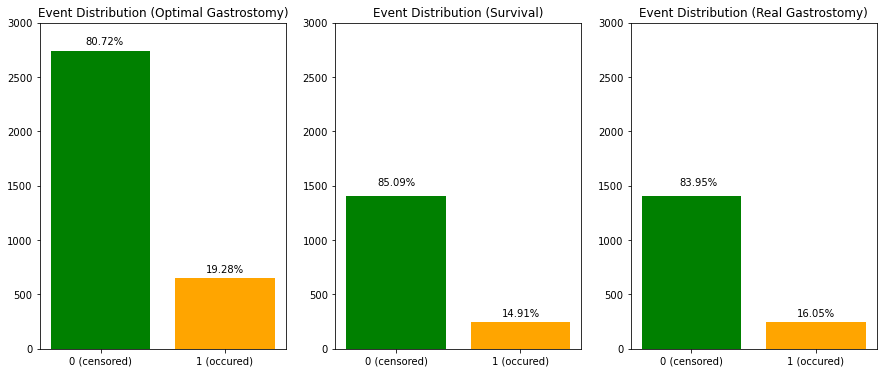

In [74]:
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.bar(event_distribution['status_o'], height=event_distribution['count'], color=['green', 'orange'])
plt.ylim([0,3000])
plt.title('Event Distribution (Optimal Gastrostomy)')
plt.text(-0.12,2800,per_0)
plt.text(0.85,700,per_1)

plt.subplot(132)
plt.bar(event_distribution_2['status_surv'], height=event_distribution_2['count'], color=['green', 'orange'])
plt.ylim([0,3000])
plt.title('Event Distribution (Survival)')
plt.text(-0.15,1500,perc_0)
plt.text(0.85,300,perc_1)

plt.subplot(133)
plt.bar(event_distribution_3['status_real'], height=event_distribution_2['count'], color=['green', 'orange'])
plt.ylim([0,3000])
plt.title('Event Distribution (Real Gastrostomy)')
plt.text(-0.1,1500,pe_0)
plt.text(0.85,300,pe_1)

plt.show()